# import essential librarys and Set up GPU 

In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from collections import namedtuple
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
pd.set_option('display.max_colwidth', 1000)

#set up GPU (optional)
import os
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib
import sys

gpus=tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 2 , 'CPU': 4} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

tf.debugging.set_log_device_placement(False)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Failed to detect a GPU.


# Reading & Processing Raw Current Signal From PSCAD Simulations

In [2]:
Faults= ["T2T","IW","Winding","Ex","Inrush"]

File= namedtuple("File",['Type','Intensity','path'])
out_files=[]
p=Path('./Pscad')
for item in p.glob('**/*'):
    name_=item.name.split(".")
    if (name_[-1]=="out"):
        name_=name_[0].split("_")
        if( name_[0] in Faults):
            Fault= name_[0]
            Type= name_[1]
            path=Path.resolve(item)
            out_files.append(File(Fault,Type,path))
        
dfSource=pd.DataFrame(out_files)
dfSource.tail()

,Type,Intensity,path
1831,Winding,r00260,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00260_01.out
1832,Winding,r00261,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00261_01.out
1833,Winding,r00262,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00262_01.out
1834,Winding,r00263,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00263_01.out
1835,Winding,r00264,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00264_01.out


In [3]:
df = pd.DataFrame()
pd.set_option("display.precision", 8)

for index, row in dfSource[(dfSource.Type=="T2T")].iterrows():
    data=pd.read_csv(row["path"],header=None,sep='\s+')
    
    # extracting data between 0.2s and 0.25s ( during fault occurance)
    data=data[(data.iloc[:,0]>=0.2) & (data.iloc[:,0]<0.25)]
    range_=0
    if (row.Type=="Inrush" and row.Intensity=="2T2" ):
        row["Resistance"]= data.iloc[0,1]
        row["Location"]= data.iloc[0,3]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= 0
        range_=range(4,10)
    elif (row.Type=="Inrush" and row.Intensity=="Winding" ):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["Location"]= data.iloc[0,3]
        row["F_time (s)"]= 0.1
        row["F_type"]= data.iloc[0,4]
        range_=range(5,11)
    elif (row.Type=="Inrush" and row.Intensity=="R" ):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["Location"]= 0
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="Inrush" and (row.Intensity=="E" or row.Intensity=="S" )):
        row["Resistance"]= 0
        row["Sw_time(s)"]= data.iloc[0,4]
        row["Location"]= data.iloc[0,1]
        row["F_time (s)"]= data.iloc[0,2]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="Ex"):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,2]
        row["F_time (s)"]= data.iloc[0,4]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="T2T" or row.Type=="IW"):
        row["Resistance"]= data.iloc[0,7]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,8]
        row["F_time (s)"]= data.iloc[0,9]
        row["F_type"]= 0
        range_=range(1,7)
    elif (row.Type=="Winding"):
        row["Resistance"]= data.iloc[0,7]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,8]
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= data.iloc[0,9]
        range_=range(1,7)
   
    dummy=pd.Series(dtype='float64')
    for i in range_:
        dummy=dummy.append(data.iloc[:,i].T,ignore_index=1)
    dummy=dummy.append(row)
    df=df.append(dummy,ignore_index=True)
    
conditions = [ (df.Type.eq("T2T") | df.Type.eq("IW") | df.Type.eq("Winding")),
               (df.Type.eq("Inrush") | df.Type.eq("Ex"))]

choices = ["in","ex"]

df['Group'] = np.select(conditions, choices, default=0)

# df.loc[df.Type == "Winding", 'Intensity'] = "Winding"
# df.loc[df.Type == "Ex", 'Intensity'] = "Ex"
df.loc[df.Type == "T2T", 'Intensity'] = "T2T"
# df.loc[df.Type == "IW", 'Intensity'] = "IW"
# df.Intensity.replace("2T2","E-T2T",inplace= True)
# df.loc[(df.Intensity == "Winding") & (df.Type == "Inrush")  , 'Intensity'] = "E-Winding"

df.rename({'Intensity':'Subgroup'}, axis=1 ,inplace = True)

df_new=df.copy()
df_new.tail()

,0,1,2,3,4,5,6,7,8,9,...,1199,F_time (s),F_type,Subgroup,Location,Resistance,Sw_time(s),Type,path,Group
211,0.01375029,0.01732791,0.02079775,0.02413847,0.02732939,0.03035062,0.03318319,0.03580929,0.03821240,0.04037746,...,0.22392026,0.209999,0.0,T2T,1.0,0.10,0.0,T2T,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_T2T.gf46\T2T_50_r00068_01.out,in
212,0.20943066,0.73870053,1.22927140,1.45189964,1.67187177,1.72912557,2.09718270,2.55671795,3.20163459,3.84656907,...,1.66817041,0.200000,0.0,T2T,1.0,0.01,0.0,T2T,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_T2T.gf46\T2T_50_r00069_01.out,in
213,0.01375029,0.01732791,0.02079775,0.02413847,0.02732939,0.03035062,0.03318319,0.03580929,0.03821240,0.04037746,...,1.78043320,0.203333,0.0,T2T,1.0,0.01,0.0,T2T,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_T2T.gf46\T2T_50_r00070_01.out,in
214,0.01375029,0.01732791,0.02079775,0.02413847,0.02732939,0.03035062,0.03318319,0.03580929,0.03821240,0.04037746,...,1.03474415,0.206666,0.0,T2T,1.0,0.01,0.0,T2T,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_T2T.gf46\T2T_50_r00071_01.out,in
215,0.01375029,0.01732791,0.02079775,0.02413847,0.02732939,0.03035062,0.03318319,0.03580929,0.03821240,0.04037746,...,0.21375150,0.209999,0.0,T2T,1.0,0.01,0.0,T2T,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_T2T.gf46\T2T_50_r00072_01.out,in


In [404]:
df = pd.DataFrame()
pd.set_option("display.precision", 8)

for index, row in dfSource.iterrows():
    data=pd.read_csv(row["path"],header=None,sep='\s+')
    
    # extracting data between 0.2s and 0.25s ( during fault occurance)
    data=data[(data.iloc[:,0]>=0.2) & (data.iloc[:,0]<0.25)]
    range_=0
    if (row.Type=="Inrush" and row.Intensity=="2T2" ):
        row["Resistance"]= data.iloc[0,1]
        row["Location"]= data.iloc[0,3]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= 0
        range_=range(4,10)
    elif (row.Type=="Inrush" and row.Intensity=="Winding" ):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["Location"]= data.iloc[0,3]
        row["F_time (s)"]= 0.1
        row["F_type"]= data.iloc[0,4]
        range_=range(5,11)
    elif (row.Type=="Inrush" and row.Intensity=="R" ):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= data.iloc[0,2]
        row["Location"]= 0
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="Inrush" and (row.Intensity=="E" or row.Intensity=="S" )):
        row["Resistance"]= 0
        row["Sw_time(s)"]= data.iloc[0,4]
        row["Location"]= data.iloc[0,1]
        row["F_time (s)"]= data.iloc[0,2]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="Ex"):
        row["Resistance"]= data.iloc[0,1]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,2]
        row["F_time (s)"]= data.iloc[0,4]
        row["F_type"]= data.iloc[0,3]
        range_=range(5,11)
    elif (row.Type=="T2T" or row.Type=="IW"):
        row["Resistance"]= data.iloc[0,7]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,8]
        row["F_time (s)"]= data.iloc[0,9]
        row["F_type"]= 0
        range_=range(1,7)
    elif (row.Type=="Winding"):
        row["Resistance"]= data.iloc[0,7]
        row["Sw_time(s)"]= 0
        row["Location"]= data.iloc[0,8]
        row["F_time (s)"]= data.iloc[0,10]
        row["F_type"]= data.iloc[0,9]
        range_=range(1,7)
   
    dummy=pd.Series(dtype='float64')
    for i in range_:
        dummy=dummy.append(data.iloc[:,i].T,ignore_index=1)
    dummy=dummy.append(row)
    df=df.append(dummy,ignore_index=True)
    
conditions = [ (df.Type.eq("T2T") | df.Type.eq("IW") | df.Type.eq("Winding")),
               (df.Type.eq("Inrush") | df.Type.eq("Ex"))]

choices = ["in","ex"]

df['Group'] = np.select(conditions, choices, default=0)

df.loc[df.Type == "Winding", 'Intensity'] = "Winding"
df.loc[df.Type == "Ex", 'Intensity'] = "Ex"
df.loc[df.Type == "T2T", 'Intensity'] = "T2T"
df.loc[df.Type == "IW", 'Intensity'] = "IW"
df.Intensity.replace("2T2","E-T2T",inplace= True)
df.loc[(df.Intensity == "Winding") & (df.Type == "Inrush")  , 'Intensity'] = "E-Winding"

df.rename({'Intensity':'Subgroup'}, axis=1 ,inplace = True)

df.to_excel("Complete_Data.xlsx")
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1199,F_time (s),F_type,Subgroup,Location,Resistance,Sw_time(s),Type,path,Group
1831,0.01434284,0.01811266,0.02176928,0.02529018,0.02865355,0.03183838,0.03482469,0.03759371,0.04012806,0.04241187,...,-0.14372738,0.209999,1.0,Winding,5.0,0.100,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,in
1832,0.59920278,0.90586237,1.47643683,1.91111928,2.30849639,2.83200957,3.27355641,3.87851383,4.61418095,5.50892072,...,0.86782295,0.200000,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,in
1833,0.01434284,0.01811266,0.02176928,0.02529018,0.02865355,0.03183838,0.03482469,0.03759371,0.04012806,0.04241187,...,0.40104297,0.203333,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,in
1834,0.01434284,0.01811266,0.02176928,0.02529018,0.02865355,0.03183838,0.03482469,0.03759371,0.04012806,0.04241187,...,-0.09148742,0.206666,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,in
1835,0.01434284,0.01811266,0.02176928,0.02529018,0.02865355,0.03183838,0.03482469,0.03759371,0.04012806,0.04241187,...,-0.14555071,0.209999,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00264_01.out,in


In [729]:
p=Path('./Complete_Data.xlsx')
df=pd.read_excel(p)
df.drop(df.columns[0],inplace=True,axis=1)
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1199,F_time (s),F_type,Subgroup,Location,Resistance,Sw_time(s),Type,path,Group
1831,0.014343,0.018113,0.021769,0.025290,0.028654,0.031838,0.034825,0.037594,0.040128,0.042412,...,-0.143727,0.209999,1.0,Winding,5.0,0.100,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,in
1832,0.599203,0.905862,1.476437,1.911119,2.308496,2.832010,3.273556,3.878514,4.614181,5.508921,...,0.867823,0.200000,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,in
1833,0.014343,0.018113,0.021769,0.025290,0.028654,0.031838,0.034825,0.037594,0.040128,0.042412,...,0.401043,0.203333,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,in
1834,0.014343,0.018113,0.021769,0.025290,0.028654,0.031838,0.034825,0.037594,0.040128,0.042412,...,-0.091487,0.206666,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,in
1835,0.014343,0.018113,0.021769,0.025290,0.028654,0.031838,0.034825,0.037594,0.040128,0.042412,...,-0.145551,0.209999,1.0,Winding,5.0,0.001,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00264_01.out,in


In [4]:
df.Type.unique()

array(['Inrush', 'Ex', 'IW', 'T2T', 'Winding'], dtype=object)

# extract one cycle

In [7]:
cycle_df=pd.DataFrame()
for index, row in df.iterrows():
    next_ph=200  
    if (row.Type=="Inrush"):
        Start_idx=round(((row["Sw_time(s)"]- 0.2)/.003333)*13.3333)
        End_idx=80   
        dummy=pd.Series(dtype='float64')
        for i in range(6):
            dummy=dummy.append(row[Start_idx:Start_idx+End_idx],ignore_index=1)
            Start_idx+=next_ph
        dummy=dummy.append(row[-8:])
    else:
        Start_idx=round(((row["F_time (s)"]- 0.2)/.003333)*13.3333)
        End_idx=80   
        dummy=pd.Series(dtype='float64')
        for i in range(6):
            dummy=dummy.append(row[Start_idx:Start_idx+End_idx],ignore_index=1)
            Start_idx+=next_ph
        dummy=dummy.append(row[-9:])
    cycle_df=cycle_df.append(dummy,ignore_index=True)
cycle_df=cycle_df.fillna(0)
cycle_df.to_excel("Cycle_Data.xlsx")
cycle_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,479,F_type,Group,Location,Resistance,Subgroup,Sw_time(s),Type,path,F_time (s)
1831,-0.60021399,-0.90682722,-1.47725401,-1.91164832,-2.30869706,-2.83187469,-3.27305145,-3.87758757,-4.61277064,-5.50690104,...,0.21126853,1.0,in,5.0,0.100,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,0.209999
1832,0.59920278,0.90586237,1.47643683,1.91111928,2.30849639,2.83200957,3.27355641,3.87851383,4.61418095,5.50892072,...,-0.21575780,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,0.200000
1833,0.04878389,1.46378225,2.87091500,3.44375557,3.62651099,3.88915060,4.78626275,5.21571534,6.07728581,6.95756509,...,0.36185799,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,0.203333
1834,0.83068539,1.22865609,1.41554999,1.46113487,1.41390335,1.60390306,1.45872105,1.55706277,1.62904954,1.75308204,...,0.58915718,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,0.206666
1835,-0.60032547,-0.90703552,-1.47768276,-1.91232817,-2.30961950,-2.83308061,-3.27455219,-3.87950387,-4.61520608,-5.51000228,...,0.21216918,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00264_01.out,0.209999


In [730]:
p=Path('./Cycle_Data.xlsx')
cycle_df=pd.read_excel(p)
cycle_df.drop(cycle_df.columns[0],inplace=True,axis=1)
cycle_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,479,F_type,Group,Location,Resistance,Subgroup,Sw_time(s),Type,path,F_time (s)
1831,-0.600214,-0.906827,-1.477254,-1.911648,-2.308697,-2.831875,-3.273051,-3.877588,-4.612771,-5.506901,...,0.211269,1.0,in,5.0,0.100,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,0.209999
1832,0.599203,0.905862,1.476437,1.911119,2.308496,2.832010,3.273556,3.878514,4.614181,5.508921,...,-0.215758,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,0.200000
1833,0.048784,1.463782,2.870915,3.443756,3.626511,3.889151,4.786263,5.215715,6.077286,6.957565,...,0.361858,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,0.203333
1834,0.830685,1.228656,1.415550,1.461135,1.413903,1.603903,1.458721,1.557063,1.629050,1.753082,...,0.589157,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,0.206666
1835,-0.600325,-0.907036,-1.477683,-1.912328,-2.309620,-2.833081,-3.274552,-3.879504,-4.615206,-5.510002,...,0.212169,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00264_01.out,0.209999


In [23]:
# this Df doesn't have "E-Winding" samples
cycle_df.Subgroup.unique()

array(['E-T2T', 'Winding', 'R', 'E', 'S', 'T2T', 'Ex', '20'], dtype=object)

# Plotting Current for Different side of Transformer

<AxesSubplot:>

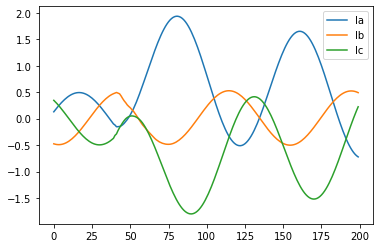

In [259]:
I_p=pd.DataFrame()
I_s=pd.DataFrame()
range_ = 200
sample_ = 1000
for i in range(1,4):
    I_p=pd.concat([I_p, df.iloc[sample_,(i-1)*range_:i*range_].T.reset_index(drop=1)],axis=1,ignore_index=1)
    I_s=pd.concat([I_s, df.iloc[sample_,3*range_+(i-1)*range_:3*range_+i*range_].T.reset_index(drop=1)],axis=1,ignore_index=1)
I_p.columns=["Ia","Ib","Ic"]
I_s.columns=["Ia","Ib","Ic"]

# Compensation
I_p=I_p*400/15.75

fig, ax_ = plt.subplots(1, 1)
I_p.plot(ax= ax_)
# I_s.plot(ax= ax_)

<AxesSubplot:>

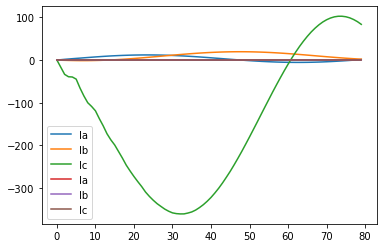

In [16]:
I_p=pd.DataFrame()
I_s=pd.DataFrame()
range_ = 80
sample_ = 10
for i in range(1,4):
    I_p=pd.concat([I_p, cycle_df.iloc[sample_,(i-1)*range_:i*range_].T.reset_index(drop=1)],axis=1,ignore_index=1)
    I_s=pd.concat([I_s, cycle_df.iloc[sample_,3*range_+(i-1)*range_:3*range_+i*range_].T.reset_index(drop=1)],axis=1,ignore_index=1)
I_p.columns=["Ia","Ib","Ic"]
I_s.columns=["Ia","Ib","Ic"]

# Compensation
I_p=I_p*400/15.75

fig, ax_ = plt.subplots(1, 1)
I_p.plot(ax= ax_)
I_s.plot(ax= ax_)

# Calculate Differntial Current for both complete dataset  & one-Cycle dataset 

In [731]:
diff_df2=df.iloc[:,:600]*400/15.75+df.iloc[:,600:1200].values
diff_df2 = pd.concat([diff_df2, df.iloc[:,1200:]], axis=1)

diff_df=cycle_df.iloc[:,:240]*400/15.75+cycle_df.iloc[:,240:480].values
diff_df = pd.concat([diff_df, cycle_df.iloc[:,480:]], axis=1)
diff_df.loc[diff_df.Type == "IW", 'Subgroup'] = "IW"
diff_df

,0,1,2,3,4,5,6,7,8,9,...,239,F_type,Group,Location,Resistance,Subgroup,Sw_time(s),Type,path,F_time (s)
0,0.099534,0.304889,0.635120,1.079353,1.541097,2.141056,2.645435,3.216672,3.815648,4.397815,...,77.889705,0.0,ex,6.0,0.001,E-T2T,0.2,Inrush,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\Inrush\Inrush+ Internal\T2T\TestSystem_Inrush.gf46\Inrush_2T2_5_r00001_01.out,0.000000
1,0.099534,0.304889,0.635120,1.079353,1.541097,2.141056,2.645435,3.216672,3.815648,4.397815,...,77.889711,0.0,ex,6.0,0.001,E-T2T,0.2,Inrush,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\Inrush\Inrush+ Internal\T2T\TestSystem_Inrush.gf46\Inrush_2T2_5_r00002_01.out,0.000000
2,0.099534,0.304889,0.635120,1.079354,1.541097,2.141056,2.645435,3.216672,3.815649,4.397815,...,77.889676,0.0,ex,6.0,0.001,E-T2T,0.2,Inrush,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\Inrush\Inrush+ Internal\T2T\TestSystem_Inrush.gf46\Inrush_2T2_5_r00003_01.out,0.000000
3,0.099534,0.304889,0.635120,1.079353,1.541097,2.141056,2.645435,3.216672,3.815648,4.397815,...,77.889705,0.0,ex,6.0,0.100,E-T2T,0.2,Inrush,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\Inrush\Inrush+ Internal\T2T\TestSystem_Inrush.gf46\Inrush_2T2_5_r00004_01.out,0.000000
4,0.099534,0.304889,0.635120,1.079353,1.541097,2.141056,2.645435,3.216672,3.815648,4.397815,...,77.889711,0.0,ex,6.0,0.100,E-T2T,0.2,Inrush,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\Inrush\Inrush+ Internal\T2T\TestSystem_Inrush.gf46\Inrush_2T2_5_r00005_01.out,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,-14.930056,-22.714200,-37.200389,-48.265763,-58.400403,-71.761062,-83.059023,-98.502349,-117.278918,-140.095856,...,-0.065401,1.0,in,5.0,0.100,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,0.209999
1832,14.926482,22.711676,37.201451,48.273922,58.416634,71.785506,83.092523,98.546177,117.334644,140.166643,...,0.063579,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,0.200000
1833,0.072256,36.224195,72.106841,86.827025,91.670153,98.545861,121.576324,132.675540,154.750489,177.288054,...,0.010781,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,0.203333
1834,20.399622,30.663468,35.550594,36.867224,35.815311,40.790550,37.226339,39.818670,41.729058,44.936826,...,-0.056624,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,0.206666


In [492]:
## Additional Half-Cycle dataset extraction

half_cycle_df=diff_df.copy()
drop_nm=72
for i in range(0,3):
    half_cycle_df.drop(half_cycle_df.iloc[:, drop_nm+i*drop_nm:80+i*drop_nm], axis=1,inplace=True)

half_cycle_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,231,F_type,Group,Location,Resistance,Subgroup,Sw_time(s),Type,path,F_time (s)
1831,-14.93005641,-22.71419950,-37.20038935,-48.26576301,-58.40040278,-71.76106178,-83.05902293,-98.50234905,-117.27891842,-140.09585608,...,-0.06841114,1.0,in,5.0,0.100,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00260_01.out,0.209999
1832,14.92648225,22.71167646,37.20145140,48.27392248,58.41663435,71.78550647,83.09252254,98.54617734,117.33464417,140.16664319,...,0.06659554,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00261_01.out,0.200000
1833,0.07225559,36.22419531,72.10684132,86.82702550,91.67015258,98.54586143,121.57632441,132.67554012,154.75048874,177.28805381,...,0.05050231,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00262_01.out,0.203333
1834,20.39962190,30.66346760,35.55059355,36.86722441,35.81531149,40.79055016,37.22633932,39.81866996,41.72905827,44.93682606,...,-0.02021322,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00263_01.out,0.206666
1835,-14.93289829,-22.71952074,-37.21134561,-48.28314291,-58.42400075,-71.79193131,-83.09746736,-98.55144778,-117.34132088,-140.17530582,...,-0.06838545,1.0,in,5.0,0.001,Winding,0.0,Winding,C:\Users\pedis\Desktop\Papers\Qatar\First Period\Pscad\TestSystem_W.gf46\Winding_r00264_01.out,0.209999


# Siamese network for Scenario 1 (2-Way K-shot)
Distinguishing between internal and external faults is a foundational task for any protection system, as internal faults pose a direct threat to the transformer's integrity and require immediate isolation to prevent catastrophic damage. This task is framed as a 2-way K-shot classification problem, where the model is provided with only a small set S ̃ of internal and external faults. This ensures reliability and reduces the risk of unnecessary tripping or damage escalation. 


In [554]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler


#### 2.5 Cycle
SF_df=diff_df2[(diff_df2.Subgroup !="E-T2T") & (diff_df2.Subgroup !="E-Winding") ]
# Normalize each phase
X = SF_df.iloc[:,:600].astype(float)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X=X.reshape(-1,200,3)


##### one-Cycle
# SF_df=diff_df[(diff_df.Subgroup !="E-T2T") & (diff_df.Subgroup !="E-Winding") ]
# # Normalize each phase
# X = SF_df.iloc[:,:240].astype(float)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X=X.reshape(-1,80,3)

#### Half Cycle
# SF_df=half_cycle_df[(half_cycle_df.Subgroup !="E-T2T") & (half_cycle_df.Subgroup !="E-Winding") ]

# # Normalize each phase
# X = SF_df.iloc[:,:drop_nm*3].astype(float)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X=X.reshape(-1,drop_nm,3)

encoder=LabelEncoder()

Y = encoder.fit_transform(SF_df["Group"])

X.shape,Y.shape,set(Y)

((1728, 200, 3), (1728,), {0, 1})

In [571]:
#load Siamese model
import imp
import models
imp.reload(models)
in_shape=(X.shape[1],X.shape[2])
siamese_net=models.load_siamese_net_1D(in_shape)
print('\nsiamese_net summary:')
siamese_net.summary()

WDCNN convnet summary:
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_164 (Conv1D)         (None, 13, 16)            3088      
                                                                 
 max_pooling1d_164 (MaxPooli  (None, 6, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_165 (Conv1D)         (None, 6, 32)             1568      
                                                                 
 max_pooling1d_165 (MaxPooli  (None, 3, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_166 (Conv1D)         (None, 3, 64)             4160      
                                                                 
 max_pooling1d_166 (MaxPooli  

In [572]:
# normalizing raw signals/ define 2 classes  / spliting to train & test
from sklearn.preprocessing import MinMaxScaler,StandardScaler

train_classes = sorted(list(set(Y)))
train_indices = [np.where(Y == i)[0] for i in train_classes]

## using different sample size
Training_size=600

num = int(Training_size/len(train_classes))

train_idxs = []
val_idxs = []
for i, c in enumerate(train_classes):
    select_idx = train_indices[i][np.random.choice(len(train_indices[i]), num, replace=False)]
    split = int(0.7*num) 
    train_idxs.extend(select_idx[:split])
    val_idxs.extend(select_idx[split:])
    
X_train_siamese, y_train_siamese = X[train_idxs],Y[train_idxs]

X_test_siamese, y_test_siamese = X[val_idxs],Y[val_idxs]


print("Training Dataset:",X_train_siamese.shape,y_train_siamese.shape)
print("\n","Test Dataset:",X_test_siamese.shape, y_test_siamese.shape)

Training Dataset: (420, 200, 3) (420,)

 Test Dataset: (180, 200, 3) (180,)


In [573]:
settings = {
  "N_way": 2,           # number of classes for one-shot tasks
  "batch_size": 512,
  "best": 0,
  "evaluate_every": 10000,   # number of iterations for evaluation
  "loss_every": 50,      # number of iterations for printing loss 
  "n_iter": 1000,
  "n_val": 2,          #number of validation tasks for one-shot
  "n": 0,
  "save_path":"2_way_weights/",
  "save_weights_file": "weights.hdf5"
}

In [574]:
import siamese_1D
imp.reload(siamese_1D)
siamese_loader = siamese_1D.Siamese_Loader(X_train_siamese,
                                y_train_siamese,
                                X_test_siamese,
                                y_test_siamese)

# best_weights_path = settings["save_path"] + settings['save_weights_file']
# siamese_net.load_weights(best_weights_path)

is_training = True
if(is_training):
    print(siamese_1D.train_and_test_oneshot(settings,siamese_net,siamese_loader))

{'train': [0, 1], 'val': [0, 1]}
420 180
[210, 210] [90, 90]
{'N_way': 2, 'batch_size': 512, 'best': -1, 'evaluate_every': 10000, 'loss_every': 50, 'n_iter': 1000, 'n_val': 2, 'n': 0, 'save_path': '2_way_weights/', 'save_weights_file': 'weights.hdf5'}
training...
950 -> Loss: 0.21729, Train_ACC: % 93.75000,
 ********* Finished ********* 
 best result on Training: % 96.67969


# Accuracy of one-shot model on testing set

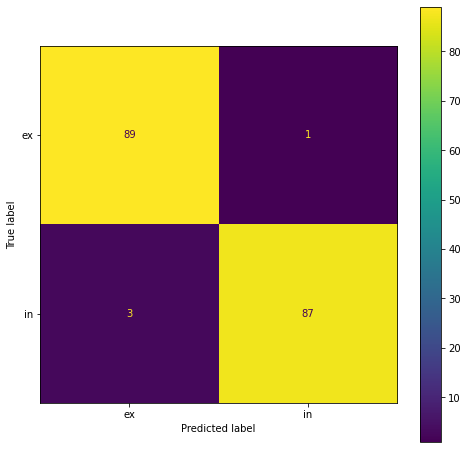

              precision    recall  f1-score   support

          ex     0.9674    0.9889    0.9780        90
          in     0.9886    0.9667    0.9775        90

    accuracy                         0.9778       180
   macro avg     0.9780    0.9778    0.9778       180
weighted avg     0.9780    0.9778    0.9778       180



In [593]:
##### one Shot model ##########
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,f1_score,classification_report

best_weights_path = settings["save_path"] + settings['save_weights_file']

siamese_net.load_weights(best_weights_path)

val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes['val']),
                                                                 len(siamese_loader.data['val']),verbose=0)
Labels_=list(encoder.inverse_transform(list(set(y_test_siamese))))

fig, ax = plt.subplots(figsize=(8, 8))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test_siamese,preds),display_labels=Labels_)
cmp.plot(ax=ax)
plt.show();

print(classification_report(y_test_siamese,preds, target_names=Labels_,digits=4))

### Accuracy of Few-shot model on testing set 

In [591]:
score_few_shot,score_few_shot_prob,preds_few_shot,prods_few_shot=siamese_loader.test_fewshot2(siamese_net,len(siamese_loader.classes['val']),
                                                 len(siamese_loader.data['val']),verbose=False,shots=5)


98.88888888888889 (180, 2) (180, 2, 1)
98.88888888888889 (180, 2) (180, 2, 1)
98.88888888888889 (180, 2) (180, 2, 1)
98.88888888888889 (180, 2) (180, 2, 1)
98.88888888888889 (180, 2) (180, 2, 1)
5_shot Accuracy based on 5 one-shot prediction: 98.88888888888889
5_shot Accuracy based on _probabilty: 98.88888888888889


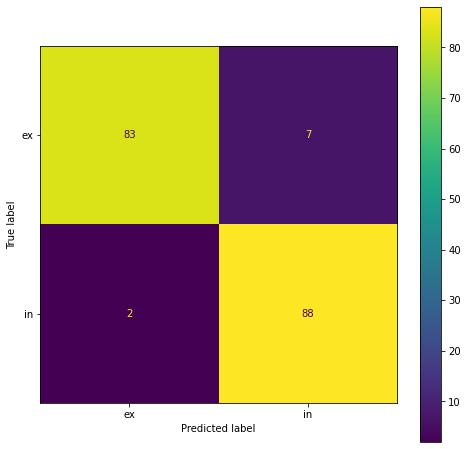

              precision    recall  f1-score   support

          ex     0.9765    0.9222    0.9486        90
          in     0.9263    0.9778    0.9514        90

    accuracy                         0.9500       180
   macro avg     0.9514    0.9500    0.9500       180
weighted avg     0.9514    0.9500    0.9500       180



In [96]:
##### Few Shot model ##########
Y_test,Y_pred=y_test_siamese,prods_few_shot

# creating a confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
Labels_=list(encoder.inverse_transform(list(set(y_test_siamese))))

cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
plt.show();

print(classification_report(Y_test,Y_pred, target_names=Labels_,digits=4))

# Performance Study Under Noise

In [ ]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def add_gaussian_noise_to_data(data, snr_dB):
    """
    Add Gaussian noise to the input data based on a specific SNR (in dB).
    
    Args:
        data: The input data (numpy array) to which noise will be added.
        snr_dB: The desired Signal-to-Noise Ratio in dB.
        
    Returns:
        noisy_data: The noisy version of the input data.
    """
    # Calculate signal power (P_signal), which is the variance of the data
    signal_power = np.var(data)
    
    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_dB / 10.0)
    
    # Calculate noise power (P_noise) from the SNR and signal power
    noise_power = signal_power / snr_linear
    
    # Generate Gaussian noise with mean 0 and calculated noise power (variance)
    noise = np.random.normal(0, np.sqrt(noise_power), data.shape)
    
    # Add the noise to the original data
    noisy_data = data + noise
    
    return noisy_data

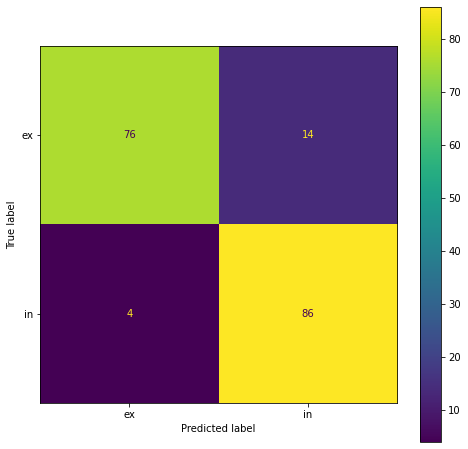

              precision    recall  f1-score   support

          ex     0.9500    0.8444    0.8941        90
          in     0.8600    0.9556    0.9053        90

    accuracy                         0.9000       180
   macro avg     0.9050    0.9000    0.8997       180
weighted avg     0.9050    0.9000    0.8997       180



In [605]:
snr_dB = 8  
noisy_X_test = add_gaussian_noise_to_data(X_test_siamese, snr_dB)

siamese_loader.set_val(noisy_X_test,y_test_siamese)

val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes['val']),
                                                                 len(siamese_loader.data['val']),verbose=0)

Labels_=list(encoder.inverse_transform(list(set(y_test_siamese))))

fig, ax = plt.subplots(figsize=(8, 8))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test_siamese,preds),display_labels=Labels_)
cmp.plot(ax=ax)
plt.show();

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,f1_score,classification_report
print(classification_report(y_test_siamese,preds, target_names=Labels_,digits=4))

# Evaluating WDCNN model for 5-way problem

### 1.Data Preparing for 5- way Problem

In [732]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler


## 2.5 Cycle
SF_df=diff_df2[(diff_df2.Subgroup !="E-T2T") & (diff_df2.Subgroup !="E-Winding") ]

# SF_df=diff_df2[(diff_df2.Subgroup !="E-T2T") & (diff_df2.Subgroup !="E-Winding") & (diff_df2.Type !='T2T') ]
# Normalize each phase
X = SF_df.iloc[:,:600].astype(float)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X=X.reshape(-1,200,3)


## Full 1 Cycle
# SF_df=diff_df[(diff_df.Subgroup !="E-T2T") & (diff_df.Subgroup !="E-Winding") ]

# # SF_df=diff_df[diff_df.Subgroup.isin( ["T2T","Winding","IW"])]

# # Normalize each phase
# X = SF_df.iloc[:,:240].astype(float)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X=X.reshape(-1,80,3)

# Half Cycle
# SF_df=half_cycle_df[(half_cycle_df.Subgroup !="E-T2T") & (half_cycle_df.Subgroup !="E-Winding") ]

# # Normalize each phase
# X = SF_df.iloc[:,:drop_nm*3].astype(float)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X=X.reshape(-1,drop_nm,3)


encoder=LabelEncoder()
Y = encoder.fit_transform(SF_df["Type"])

X.shape,Y.shape,set(Y)

((1728, 200, 3), (1728,), {0, 1, 2, 3, 4})

### 2.WDCNN Evaluation

In [734]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import imp
import models
imp.reload(models)

in_shape=(200,3)
wdcnn=models.load_wdcnn_net_1D((200,3),nclasses=5)
wdcnn.summary()

# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y  # Use stratify to maintain class balance
)

# One-hot encode labels for training and validation
Y_train_one_hot = to_categorical(Y_train, num_classes=5)
Y_val_one_hot = to_categorical(Y_val, num_classes=5)

# Train the model
history = wdcnn.fit(
    X_train, 
    Y_train_one_hot, 
    batch_size=128, 
    epochs=20, 
    validation_data=(X_val, Y_val_one_hot), 
    verbose=1)

Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 200, 3)]          0         
                                                                 
 conv1d_210 (Conv1D)         (None, 100, 16)           400       
                                                                 
 batch_normalization_65 (Bat  (None, 100, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 50, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_211 (Conv1D)         (None, 50, 32)            2080      
                                                                 
 batch_normalization_66 (Bat  (None, 50, 32)           128

### 3. WDCNN confusion matrix & t-SNE

6/6 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

          Ex     0.9138    1.0000    0.9550        53
          IW     0.7143    0.7692    0.7407        13
      Inrush     1.0000    0.9492    0.9739        59
         T2T     0.7619    0.7273    0.7442        22
     Winding     1.0000    0.9231    0.9600        26

    accuracy                         0.9191       173
   macro avg     0.8780    0.8737    0.8748       173
weighted avg     0.9218    0.9191    0.9193       173



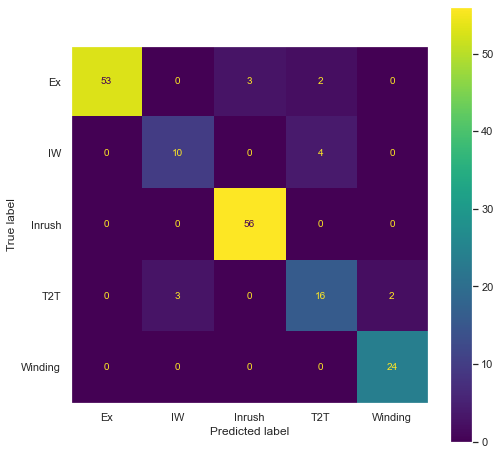

Confusion results saved to ../Picture/wdcnn_confusion_results.xlsx


In [737]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


## Load best trained model's weight if available
wdcnn.load_weights("best_trained_model/wdcnn_weights.h5")

# Generate predictions on validation set
predictions = wdcnn.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = Y_val  # Since validation labels are not one-hot encoded

# Print classification report
Labels_=list(encoder.inverse_transform(list(set(Y_val))))
print(classification_report(true_labels, predicted_labels, target_names=Labels_, digits=4))

Y_test,Y_pred=predicted_labels, true_labels

# creating a confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
ax.grid(False)
plt.show();

# Convert result to DataFrame
confusion_df = pd.DataFrame(data={'true':true_labels,'pred':predicted_labels})
# Save to Excel
excel_path = "./Picture/wdcnn_confusion_results.xlsx"
confusion_df.to_excel(excel_path, index=False)
print(f"Confusion results saved to {excel_path}")

6/6 [==============================] - 0s 11ms/step


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


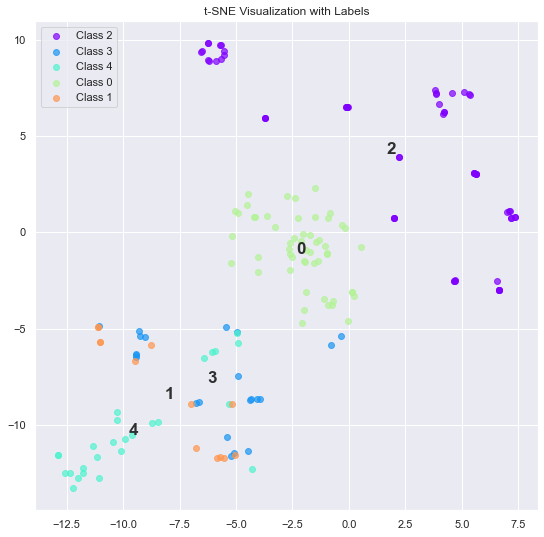

In [725]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# # Create a model to extract the last hidden layer
last_hidden_layer_model = Model(inputs=wdcnn.input, 
                                outputs=wdcnn.get_layer(index=-3).output)

# Assuming you have your test data loaded
# X_test: input data, y_test: one-hot encoded labels
last_hidden_features = last_hidden_layer_model.predict(X_val)

# Reduce the dimensionality of the last hidden layer's output with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(last_hidden_features)

# Convert t-SNE result to DataFrame
tsne_df = pd.DataFrame(data=tsne_result, columns=['x', 'y'])
tsne_df['label'] = Y_val  # Ensure labels match format

# Define the plotting function
def plot_with_labels(data):
    sns.set(rc={'figure.figsize': (9, 9)})
    plt.figure()
    num_labels = len(data['label'].unique())  # Determine number of unique labels
    colormap = cm.rainbow  # Use rainbow color map

    for i, label in enumerate(data['label'].unique()):
        plt.scatter(
            x=data.loc[data['label'] == label, 'x'],
            y=data.loc[data['label'] == label, 'y'],
            color=colormap(int(255 * i / num_labels)),
            alpha=0.7,
            label=f'Class {label}'
        )
        plt.annotate(
            str(label),
            data.loc[data['label'] == label, ['x', 'y']].mean(),
            horizontalalignment='center',
            verticalalignment='center',
            size=17,
            weight='bold',
            alpha=0.8,
            color='black'
        )

    plt.legend()
    plt.title("t-SNE Visualization with Labels")
    plt.show()

# Save to Excel
excel_path = "./Picture/few1_tsne_results.xlsx"
tsne_df.to_excel(excel_path, index=False)
print(f"t-SNE results saved to {excel_path}")


# Plot the t-SNE visualization
plot_with_labels(tsne_df)


###    4.wdcnn Performance Study Under Noise 

In [553]:
import numpy as np

def add_gaussian_noise_to_data(data, snr_dB):
    """
    Add Gaussian noise to the input data based on a specific SNR (in dB).
    
    Args:
        data: The input data (numpy array) to which noise will be added.
        snr_dB: The desired Signal-to-Noise Ratio in dB.
        
    Returns:
        noisy_data: The noisy version of the input data.
    """
    # Calculate signal power (P_signal), which is the variance of the data
    signal_power = np.var(data)
    
    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_dB / 10.0)
    
    # Calculate noise power (P_noise) from the SNR and signal power
    noise_power = signal_power / snr_linear
    
    # Generate Gaussian noise with mean 0 and calculated noise power (variance)
    noise = np.random.normal(0, np.sqrt(noise_power), data.shape)
    
    # Add the noise to the original data
    noisy_data = data + noise
    
    return noisy_data

snr_dB = 25  # Example SNR in dB
noisy_X_test = add_gaussian_noise_to_data(X_val, snr_dB)

# Now, you can evaluate the model on the noisy data
evaluation = wdcnn.evaluate(noisy_X_test, Y_val_one_hot)  

predictions = wdcnn.predict(noisy_X_test)

print(f"Evaluation on noisy data: {evaluation}")


11/11 [==============================] - 0s 11ms/step
Evaluation on noisy data: [0.4612727165222168, 0.823699414730072]


# Siamese network for Scenario 2 ( 5-Way K-shot)
This task involves detecting IW, winding faults, T2T faults, inrush currents, and external faults individually. The task is framed as a 5-way K-shot classification problem, where the model is provided with only a small S ̃ of each fault type. This capability adds significant value to the protection system by enabling precise fault identification, which aids in post-event diagnostics, root cause analysis, and the implementation of tailored corrective measures. Although this task is not strictly required in the protection paradigm, it demonstrates the proficiency of the few-DP model in addressing a wide range of faults using only few samples.

In [738]:
#load Siamese model
import imp
import models
imp.reload(models)
in_shape=(X.shape[1],X.shape[2])
siamese_net=models.load_siamese_net_1D(in_shape)
print('\nsiamese_net summary:')
# siamese_net.summary()

WDCNN convnet summary:
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_214 (Conv1D)         (None, 13, 16)            3088      
                                                                 
 max_pooling1d_214 (MaxPooli  (None, 6, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_215 (Conv1D)         (None, 6, 32)             1568      
                                                                 
 max_pooling1d_215 (MaxPooli  (None, 3, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_216 (Conv1D)         (None, 3, 64)             4160      
                                                                 
 max_pooling1d_216 (MaxPooli  

In [690]:
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer'):
            layer.bias.initializer.run(session=session) 
reset_weights(siamese_net)

In [752]:
settings = {
  "N_way": 5,           # number of classes for one-shot tasks
  "batch_size": 512,
  "best": 0,
  "evaluate_every": 10000,   # number of iterations for evaluation
  "loss_every": 50,      # number of iterations for printing loss 
  "n_iter": 1000,
  "n_val": 2,          #number of validation tasks for one-shot
  "n": 0,
  "save_path":"best_trained_model/",
  "save_weights_file": "weights.hdf5"
}

In [751]:
# normalizing raw voltage signals/ define 4 classes  / spliting to train & test
from sklearn.preprocessing import MinMaxScaler,StandardScaler

train_classes = sorted(list(set(Y)))
train_indices = [np.where(Y == i)[0] for i in train_classes]

Training_size=675
# Training_size=540

# number of samples per Class
num = int(Training_size/len(train_classes))

train_idxs = []
val_idxs = []
for i, c in enumerate(train_classes):
    select_idx = train_indices[i][np.random.choice(len(train_indices[i]), num, replace=False)]
    split = int(0.7*num) 
    train_idxs.extend(select_idx[:split])
    val_idxs.extend(select_idx[split:])
    
X_train_siamese, y_train_siamese = X[train_idxs],Y[train_idxs]

X_test_siamese, y_test_siamese = X[val_idxs],Y[val_idxs]


print("Training Dataset:",X_train_siamese.shape,y_train_siamese.shape)
print("\n","Test Dataset:",X_test_siamese.shape, y_test_siamese.shape)

Training Dataset: (470, 200, 3) (470,)

 Test Dataset: (205, 200, 3) (205,)


### Train using mode.train_on_batch method

In [753]:
# %%timeit -n1 -r1

# training the Siamese network for 12 classes
import imp
import siamese_1D
imp.reload(siamese_1D)

siamese_loader = siamese_1D.Siamese_Loader(X_train_siamese,
                                y_train_siamese,
                                X_test_siamese,
                                y_test_siamese)

# best_weights_path = settings["save_path"] + settings['save_weights_file']
# siamese_net.load_weights(best_weights_path)

print(siamese_1D.train_and_test_oneshot(settings,siamese_net,siamese_loader))

{'train': [0, 1, 2, 3, 4], 'val': [0, 1, 2, 3, 4]}
470 205
[94, 94, 94, 94, 94] [41, 41, 41, 41, 41]
{'N_way': 5, 'batch_size': 512, 'best': -1, 'evaluate_every': 10000, 'loss_every': 50, 'n_iter': 1000, 'n_val': 2, 'n': 0, 'save_path': 'best_trained_model/', 'save_weights_file': 'weights.hdf5'}
training...
950 -> Loss: 0.17355, Train_ACC: % 91.79688,
 ********* Finished ********* 
 best result on Training: % 96.09375


## Train on full dataset using mode.fit

In [263]:
import imp
import siamese_1D
imp.reload(siamese_1D)

siamese_loader = siamese_1D.Siamese_Loader(X_train_siamese,
                                y_train_siamese,
                                X_test_siamese,
                                y_test_siamese)

best_weights_path = settings["save_path"] + "best_siamese_model.h5"
siamese_net.load_weights(best_weights_path)

siamese_1D.train_full(settings,siamese_net,siamese_loader)

{'train': [0, 1, 2, 3, 4], 'val': [0, 1, 2, 3, 4]}
470 205
[94, 94, 94, 94, 94] [41, 41, 41, 41, 41]
Epoch 1/200
215/216 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy_metric: 0.6787
Epoch 1: loss improved from inf to 0.31412, saving model to best_trained_model\best_siamese_model.h5
216/216 [==============================] - 23s 107ms/step - loss: 0.3141 - accuracy_metric: 0.6786
Epoch 2/200
215/216 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy_metric: 0.6878
Epoch 2: loss improved from 0.31412 to 0.30869, saving model to best_trained_model\best_siamese_model.h5
216/216 [==============================] - 23s 108ms/step - loss: 0.3087 - accuracy_metric: 0.6881
Epoch 3/200
215/216 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy_metric: 0.6904
Epoch 3: loss improved from 0.30869 to 0.30857, saving model to best_trained_model\best_siamese_model.h5
216/216 [==============================] - 23s 108ms/step - loss: 0.3086 - acc

Epoch 31/200
216/216 [==============================] - ETA: 0s - loss: 0.2998 - accuracy_metric: 0.6990
Epoch 31: loss did not improve from 0.29899
216/216 [==============================] - 22s 103ms/step - loss: 0.2998 - accuracy_metric: 0.6990
Epoch 32/200
215/216 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy_metric: 0.7001
Epoch 32: loss improved from 0.29899 to 0.29887, saving model to best_trained_model\best_siamese_model.h5
216/216 [==============================] - 22s 103ms/step - loss: 0.2989 - accuracy_metric: 0.7004
Epoch 33/200
215/216 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy_metric: 0.7009
Epoch 33: loss improved from 0.29887 to 0.29815, saving model to best_trained_model\best_siamese_model.h5
216/216 [==============================] - 22s 103ms/step - loss: 0.2981 - accuracy_metric: 0.7011
Epoch 34/200
215/216 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy_metric: 0.7013
Epoch 34: loss improved fro

### Accuracy of one-shot model on testing set

In [754]:
best_weights_path = settings["save_path"] + settings['save_weights_file']

siamese_net.load_weights(best_weights_path)
val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes['train']),
                                                                 len(siamese_loader.data['train']),verbose=0)
print(val_acc,preds.shape, prods.shape)

81.46341463414635 (205,) (205, 5, 1)


### Accuracy of Few-shot model on testing set 

In [758]:
score_few_shot,score_few_shot_prob,preds_few_shot,prods_few_shot=siamese_loader.test_fewshot2(siamese_net,
                                len(siamese_loader.classes['val']),len(siamese_loader.data['val']),verbose=False,shots=1)

85.85365853658537 (205, 2) (205, 5, 1)
1_shot Accuracy based on 1 one-shot prediction: 85.85365853658537
1_shot Accuracy based on _probabilty: 85.85365853658537


# Confusion Matrix & T-SNE Plot

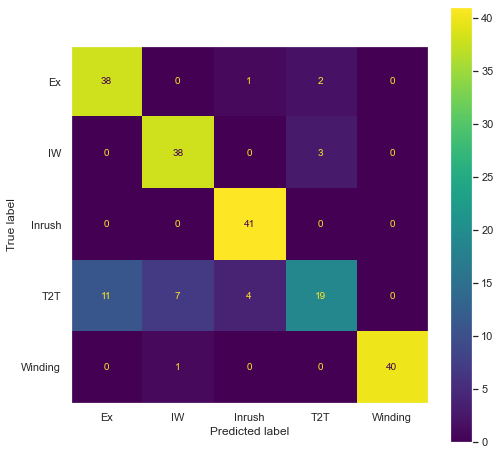

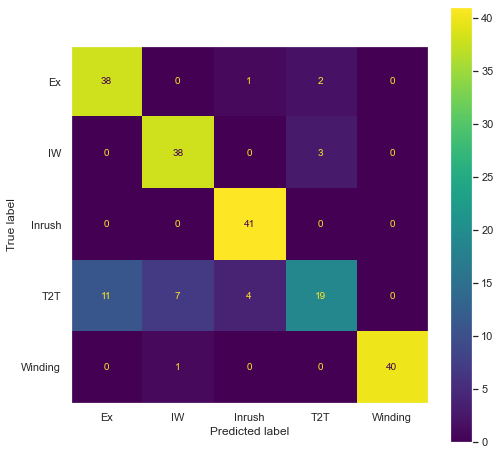

Confusion results saved to ../Picture/few2_confusion_results.xlsx


In [761]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


Y_test,Y_pred=y_test_siamese,preds_few_shot
# creating a confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(8, 8))

Labels_=list(encoder.inverse_transform(list(set(y_test_siamese))))

cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
ax.grid(False)
plt.show();


##### Few Shot model ##########
Y_test,Y_pred=y_test_siamese,prods_few_shot
# creating a confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
Labels_=list(encoder.inverse_transform(list(set(y_test_siamese))))
cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
ax.grid(False)
plt.show();

# Convert result to DataFrame
confusion_df = pd.DataFrame(data={'true':Y_test,'pred':Y_pred})
# Save to Excel
excel_path = "./Picture/few2_confusion_results.xlsx"
confusion_df.to_excel(excel_path, index=False)
print(f"Confusion results saved to {excel_path}")

In [505]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,f1_score,classification_report

print(classification_report(predicted_labels, true_labels, target_names=Labels_,digits=4))

              precision    recall  f1-score   support

          Ex     0.5000    0.2000    0.2857         5
          IW     0.5000    0.5000    0.5000         2
      Inrush     0.0000    0.0000    0.0000         1
         T2T     0.5000    1.0000    0.6667         1
     Winding     0.5000    1.0000    0.6667         1

    accuracy                         0.4000        10
   macro avg     0.4000    0.5400    0.4238        10
weighted avg     0.4500    0.4000    0.3762        10



### T-SNE

In [718]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# # Create a model to extract the last hidden layer
last_hidden_layer_model = Model(inputs=siamese_net.input, 
                                outputs=siamese_net.get_layer('sequential_37').output)

X_left = X_train_siamese[:-1]  # All but the last sample
X_right = X_train_siamese[1:]  # All but the first sample

# Assuming you have your test data loaded
# X_test: input data, y_test: one-hot encoded labels
last_hidden_features = last_hidden_layer_model.predict([X_left, X_right])

# Reduce the dimensionality of the last hidden layer's output with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(last_hidden_features)

# Convert t-SNE result to DataFrame
tsne_df = pd.DataFrame(data=tsne_result, columns=['x', 'y'])
tsne_df['label'] = y_train_siamese  # Ensure labels match format

# Define the plotting function
def plot_with_labels(data):
    sns.set(rc={'figure.figsize': (9, 9)})
    plt.figure()
    num_labels = len(data['label'].unique())  # Determine number of unique labels
    colormap = cm.rainbow  # Use rainbow color map

    for i, label in enumerate(data['label'].unique()):
        plt.scatter(
            x=data.loc[data['label'] == label, 'x'],
            y=data.loc[data['label'] == label, 'y'],
            color=colormap(int(255 * i / num_labels)),
            alpha=0.7,
            label=f'Class {label}'
        )
        plt.annotate(
            str(label),
            data.loc[data['label'] == label, ['x', 'y']].mean(),
            horizontalalignment='center',
            verticalalignment='center',
            size=17,
            weight='bold',
            alpha=0.8,
            color='black'
        )

    plt.legend()
    plt.title("t-SNE Visualization with Labels")
    plt.show()

# Plot the t-SNE visualization
plot_with_labels(tsne_df)


# Save to Excel
excel_path = "./Picture/wdcnn_tsne_results.xlsx"
tsne_df.to_excel(excel_path, index=False)
print(f"t-SNE results saved to {excel_path}")


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='conv1d_193_input'), name='conv1d_193_input', description="created by layer 'conv1d_193_input'") at layer "conv1d_193". The following previous layers were accessed without issue: []

### SVM Model Evaluation

In [330]:
from sklearn import svm

clf = svm.SVC(kernel='rbf') 

#Train the model using the training sets
clf.fit(X_train, Y_train)

# X_train, X_val, Y_train, Y_val
#Predict the response for test dataset
y_pred = clf.predict(noisy_X_test)

print(classification_report(Y_val, y_pred,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     0.6667    1.0000    0.8000         2
           2     1.0000    0.5000    0.6667         2

    accuracy                         0.8333         6
   macro avg     0.8889    0.8333    0.8222         6
weighted avg     0.8889    0.8333    0.8222         6



#  Model Evaluation on Unseen Transformer 
It is usually common to have different types of power transformer (i.e., in terms of connection type, rating, and operating conditions) in the grid, making it impractical to collect sufficient data for each configuration to train a reliable AI-based differential protection (DP) system. For this reason, the thirdchallenge of diagnosing faults in a new unseen transformer, for which no prior data is available during training, remains significant. To evaluate the proposed Few-DP in this case, faults related to the 4th transformer in Fig.3 are used as the training set, while faults from the 3rd transformer are used for evaluation. This setup ensures D_Train∩ D_Test= ∅, meaning the testing transformer is entirely unseen during training. Furthermore, D_Test is divided into a support set S ̃_(K×N) and test set T ̃, with S ̃_(K×N)∩ T ̃= ∅. Another important factor influencing the performance is the variation in connection types among transformers. this issue is resolved in compensation step of the data layer to avoid time shifts and large model errors.

In [ ]:
train_classes = sorted(list(set(Y)))
train_indices = [np.where(Y == i)[0] for i in train_classes]
unseen_group=[1,2,3,4]
train_classes = [ele for ele in train_classes if ele not in unseen_group]
unseen_class_indices = [np.where(Y == ele)[0]  for ele in unseen_group]
unseenclass_select_idx=[]
for i in range(len(unseen_group)):
    select_idx=unseen_class_indices[i][np.random.choice(len(unseen_class_indices[i]), 5, replace=False)]
    unseenclass_select_idx.extend(select_idx)
unseenclass_select_idx
train_indices = [np.where(Y == i)[0] for i in train_classes]


train_idxs = []
val_idxs = []
for i, c in enumerate(train_classes):
    select_idx = train_indices[i][np.random.choice(len(train_indices[i]), 5, replace=False)]   
    train_idxs.extend(select_idx)

X_train_siamese, y_train_siamese = X[train_idxs],Y[train_idxs]

val_idxs=train_idxs.copy()
for i in range(len(unseen_group)):
    val_idxs.extend(unseen_class_indices[i].tolist())
X_val_siamese, y_val_siamese = np.delete(X,val_idxs, 0),Y.drop(val_idxs)

test_idxs=train_idxs.copy()
test_idxs.extend(unseenclass_select_idx)

X_test_siamese, y_test_siamese= np.delete(X,test_idxs, 0),Y.drop(test_idxs)

print(X_train_siamese.shape,y_train_siamese.shape)
print(X_val_siamese.shape,y_val_siamese.shape)
print(X_test_siamese.shape, y_test_siamese.shape)

In [241]:
settings = {
  "N_way": len(set(Y))-len(unseen_group),           # how many classes for testing one-shot tasks>
  "batch_size": 32,
  "best": -1,
  "evaluate_every": 25,   # interval for evaluating on one-shot tasks
  "loss_every": 20,      # interval for printing loss (iterations)
  "n_iter": 400,
  "n_val": 2,          #how many one-shot tasks to validate on?
  "n": 0,
}

In [301]:
import imp
import siamese_1D
imp.reload(siamese_1D)

is_training = True

siamese_loader = siamese_1D.Siamese_Loader(X_train_siamese,
                                y_train_siamese,
                                X_val_siamese,
                                y_val_siamese)

if(is_training):
    print(siamese_1D.train_and_test_oneshot(settings,siamese_net,siamese_loader))

{'train': [0, 1, 4, 5, 6, 7, 8, 9, 10, 11], 'val': [0, 1, 4, 5, 6, 7, 8, 9, 10, 11]}
40 40
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4] [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
{'N_way': 10, 'batch_size': 32, 'best': -1, 'evaluate_every': 25, 'loss_every': 20, 'n_iter': 400, 'n_val': 2, 'n': 0, 'save_path': 'tmp2', 'save_weights_file': 'weights.hdf5'}
****************************************training****************************************
Evaluating model on 40 random 10 way one-shot learning tasks ...

iteration 0 evaluating: 60.0%
interation 40, Loss: 0.26154,
iteration 50 evaluating: 77.5%
interation 60, Loss: 0.24465,
iteration 75 evaluating: 80.0%
interation 120, Loss: 0.13670,
iteration 125 evaluating: 80.0%
interation 380, Loss: 0.05551,80.0


### Unseen-Class one-shot testing

In [303]:
# change val and train dataset to include unseen_class_idx
X_train_unseen, y_train_unseen = X[test_idxs],Y[test_idxs]

siamese_loader.set_val(X_test_siamese, y_test_siamese)
siamese_loader.set_train(X_train_unseen, y_train_unseen)

val_acc,preds, prods = siamese_loader.test_oneshot2(siamese_net,len(siamese_loader.classes['val']),
                                                                 len(siamese_loader.data['val']),verbose=0)
print(val_acc,preds.shape, prods.shape)

62.5 (48, 2) (48, 12, 1)


### Unseen-Class few-shot testing

In [304]:
score_few_shot,score_few_shot_prob,preds_few_shot,prods_few_shot=siamese_loader.test_fewshot2(siamese_net,len(siamese_loader.classes['val']),
                                                 len(siamese_loader.data['val']),verbose=False,shots=4)

70.83333333333333 (48, 2) (48, 12, 1)
64.58333333333333 (48, 2) (48, 12, 1)
68.75 (48, 2) (48, 12, 1)
66.66666666666667 (48, 2) (48, 12, 1)
4_shot Accuracy based on 4 one-shot prediction: 66.66666666666666
4_shot Accuracy based on _probabilty: 70.83333333333334
